In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score,accuracy_score
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('dataset.csv')

In [3]:
# Drop unnecessary columns
df.drop(["user_id", "product_id"], axis=1, inplace=True)

In [4]:
# One-Hot Encoding for categorical features
nominal_columns = ['user_gender', 'user_location', 'user_browser', 'user_device', 'category', 'product_color', 'product_size', 'referral_source', 'time_of_day', 'day_of_week', 'season', 'payment_method', 'seller_location','user_education']
df = pd.get_dummies(df, columns=nominal_columns, drop_first=True)

In [5]:
# Label Encoding for ordinal categorical variables
label_cols = {'user_membership': ['Free', 'Silver', 'Gold', 'Platinum'],
              'stock_status': ['Low', 'Medium', 'High']}

for col in label_cols.keys():
    df[col] = df[col].astype('category').cat.codes

In [6]:
# Feature Engineering
df['spending_per_minute'] = df['average_spent'] / (df['session_duration'] + 1)
df['cart_to_purchase_ratio'] = df['add_to_cart_count'] / (df['purchase_history'] + 1)
df['ad_to_click_ratio'] = df['clicks_on_ads'] / (df['purchase_history'] + 1)
df['purchase_history'] = df['purchase_history'].astype(int)

In [7]:
# Time Encoding
day_columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_mapping = {f"day_of_week_{day}": idx for idx, day in enumerate(day_columns)}

# Ensure the DataFrame contains relevant one-hot encoded columns
day_columns_present = [col for col in df.columns if col in day_mapping]

if day_columns_present:  # Only proceed if columns exist
    df['day_index'] = df[day_columns_present].dot([day_mapping[col] for col in day_columns_present])
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_index'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_index'] / 7)
    df.drop(columns=['day_index'], inplace=True)
else:
    df['day_of_week_sin'] = 0  # Assign default values to avoid missing columns
    df['day_of_week_cos'] = 0


In [8]:
# Time of Day Encoding
time_periods = {'Morning': 9, 'Evening': 18, 'Night': 0}

# Ensure the DataFrame contains relevant one-hot encoded columns
time_columns_present = [col for col in df.columns if col in [f'time_of_day_{key}' for key in time_periods]]

if time_columns_present:  # Only proceed if columns exist
    df['time_index'] = df[time_columns_present].dot([time_periods[col.split('_')[-1]] for col in time_columns_present])
    df['time_of_day_sin'] = np.sin(2 * np.pi * df['time_index'] / 24)
    df['time_of_day_cos'] = np.cos(2 * np.pi * df['time_index'] / 24)
    df.drop(columns=['time_index'], inplace=True)
else:
    df['time_of_day_sin'] = 0  # Assign default values to avoid missing columns
    df['time_of_day_cos'] = 0

In [9]:
# Additional Features
df['engagement_score'] = df['user_engagement_score'] + df['page_views'] + df['session_duration']

In [10]:
# Standardization
numeric_cols = ["price", "rating", "review_count", "user_age", "user_income", "user_engagement_score", 
                "session_duration", "clicks_on_ads", "page_views", "wishlist_additions", 
                "cart_abandonment_rate", "time_to_purchase", "delivery_time", 
                "shipping_fee", "seller_rating", "seller_response_time", 
                "review_sentiment_score", "discount_percentage", "product_popularity"]
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [11]:
# Convert datetime features
df['purchase_time'] = pd.to_datetime(df['purchase_time'])
df['hour'] = df['purchase_time'].dt.hour
df['day_of_week'] = df['purchase_time'].dt.weekday
df['month'] = df['purchase_time'].dt.month
df.drop(columns=['purchase_time'], inplace=True)

In [12]:
# Convert Boolean Features
bool_columns = ['is_top_seller', 'purchase_history', 'discount_applied', 'coupon_used']
df[bool_columns] = df[bool_columns].astype(int)

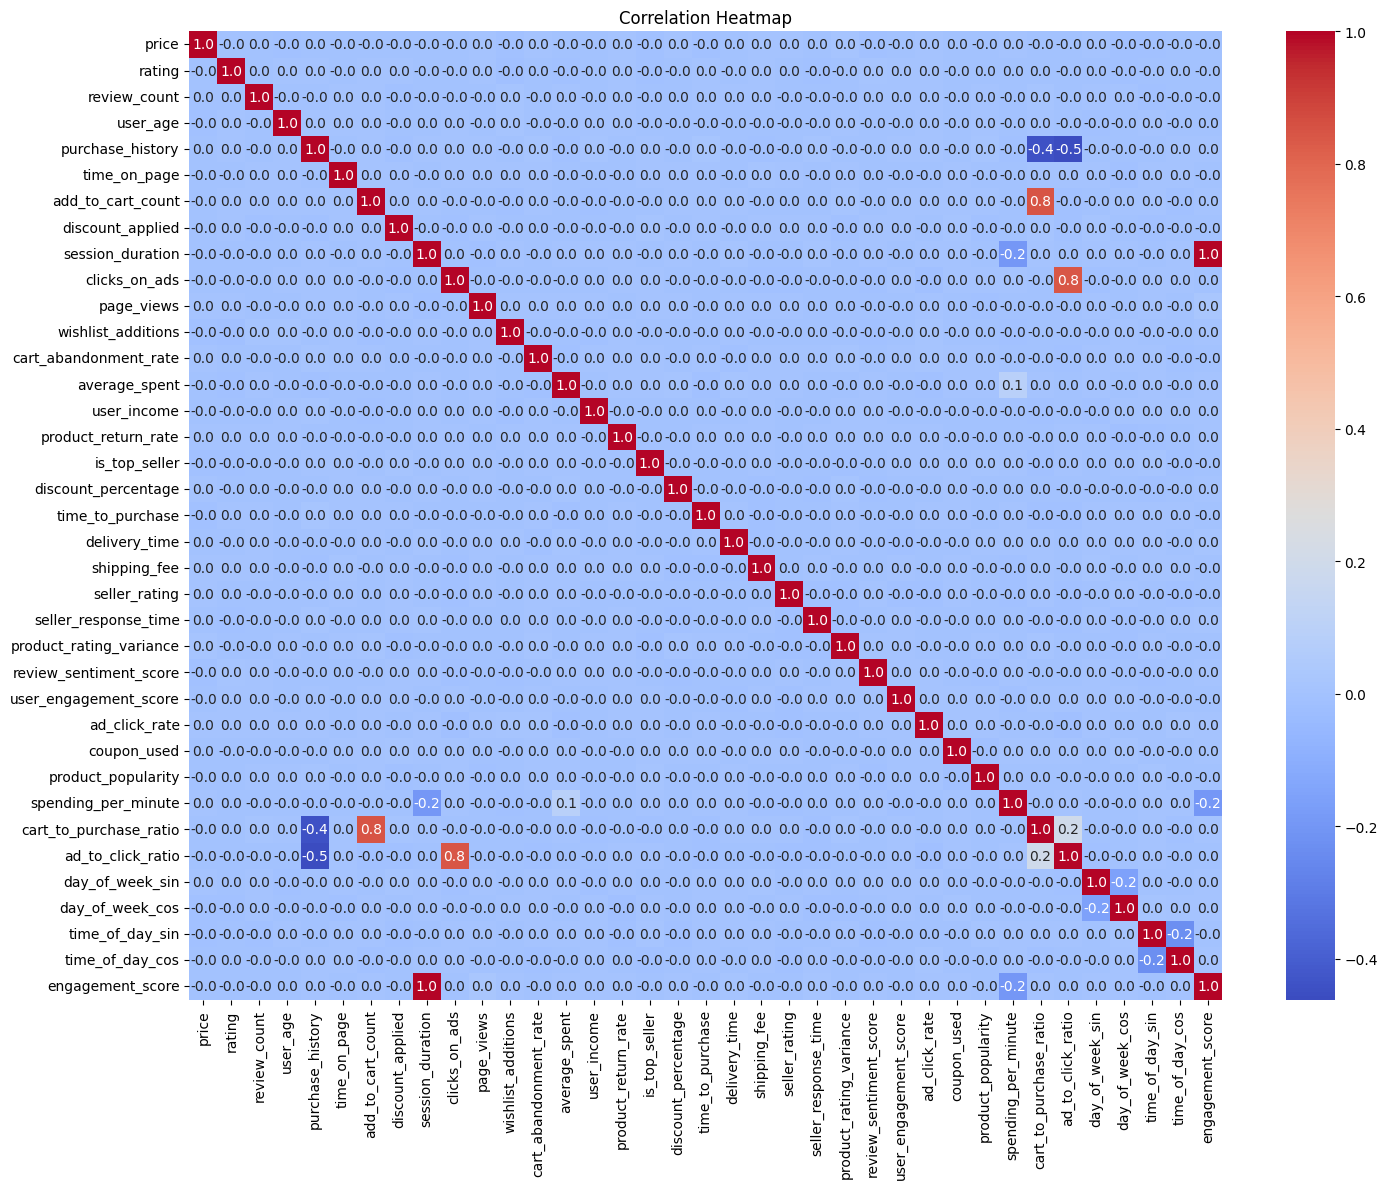

In [13]:
# Ensure only numerical columns are selected
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Check if DataFrame is empty (i.e., no numeric columns)
if numeric_df.empty:
    print("No numerical columns found for correlation heatmap.")
else:
    # Visualization - Correlation Heatmap
    plt.figure(figsize=(15, 12))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.1f')
    plt.title('Correlation Heatmap')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

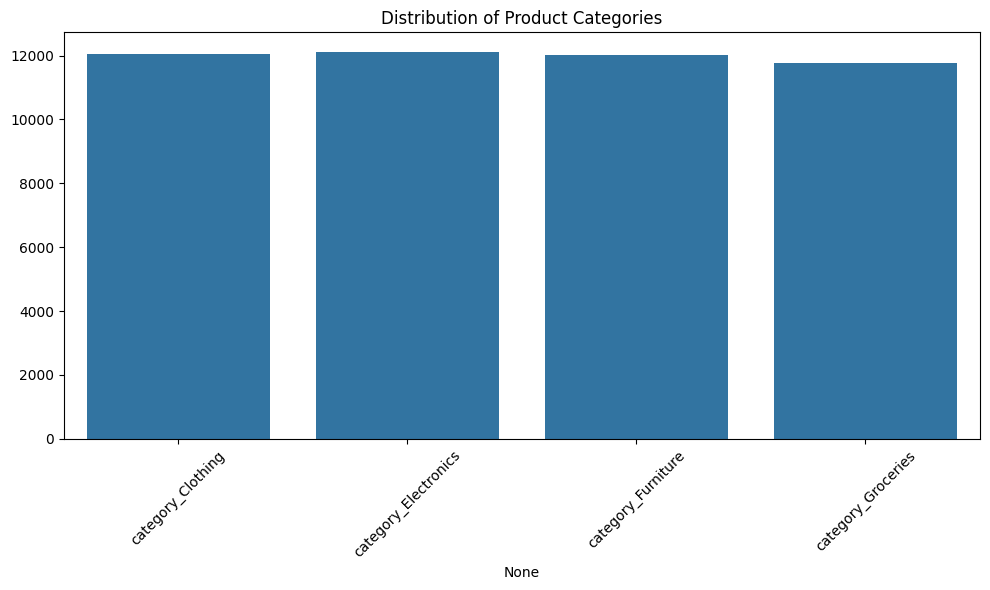

In [14]:
# Visualization - Product Categories
category_counts = df.filter(like="category_").sum()
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title('Distribution of Product Categories')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
# Split Data
target = "purchase_history"
X = df.drop(columns=[target])
y = df[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [16]:
# Identify categorical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Apply Label Encoding to categorical columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le  # Store encoders for future use

# Train RandomForest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)  # ✅ Now, all features are numerical
rf_preds = rf_model.predict(X_test)
rf_probs = rf_model.predict_proba(X_test)[:, 1]

In [17]:
# Train XGBoost Classifier
from xgboost import XGBClassifier


xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.05, random_state=42, use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

In [18]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

def evaluate_model(name, y_test, preds, probs):
    print(f"\n📌 **{name} Model Performance:**\n")
    print(f"✅ Accuracy: {accuracy_score(y_test, preds):.4f}")
    print(f"✅ Precision: {precision_score(y_test, preds):.4f}")
    print(f"✅ Recall: {recall_score(y_test, preds):.4f}")
    print(f"✅ F1-Score: {f1_score(y_test, preds):.4f}")
    print(f"✅ ROC-AUC: {roc_auc_score(y_test, probs):.4f}")
    
    print("\n🔹 Classification Report:\n", classification_report(y_test, preds))
    print("\n🔹 Confusion Matrix:")
    print(confusion_matrix(y_test, preds))

In [19]:
# Evaluate RandomForest
evaluate_model("Random Forest", y_test, rf_preds, rf_probs)

# Evaluate XGBoost
evaluate_model("XGBoost", y_test, xgb_preds, xgb_probs)


📌 **Random Forest Model Performance:**

✅ Accuracy: 0.9685
✅ Precision: 0.9412
✅ Recall: 0.9997
✅ F1-Score: 0.9695
✅ ROC-AUC: 0.9988

🔹 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97      8974
           1       0.94      1.00      0.97      9026

    accuracy                           0.97     18000
   macro avg       0.97      0.97      0.97     18000
weighted avg       0.97      0.97      0.97     18000


🔹 Confusion Matrix:
[[8410  564]
 [   3 9023]]

📌 **XGBoost Model Performance:**

✅ Accuracy: 0.9980
✅ Precision: 0.9960
✅ Recall: 1.0000
✅ F1-Score: 0.9980
✅ ROC-AUC: 1.0000

🔹 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8974
           1       1.00      1.00      1.00      9026

    accuracy                           1.00     18000
   macro avg       1.00      1.00      1.00     18000
weighted avg       1.00      1.00    

In [20]:
# Feature Importance Analysis
feature_importance = pd.DataFrame({"Feature": X.columns, "Importance": rf_model.feature_importances_})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

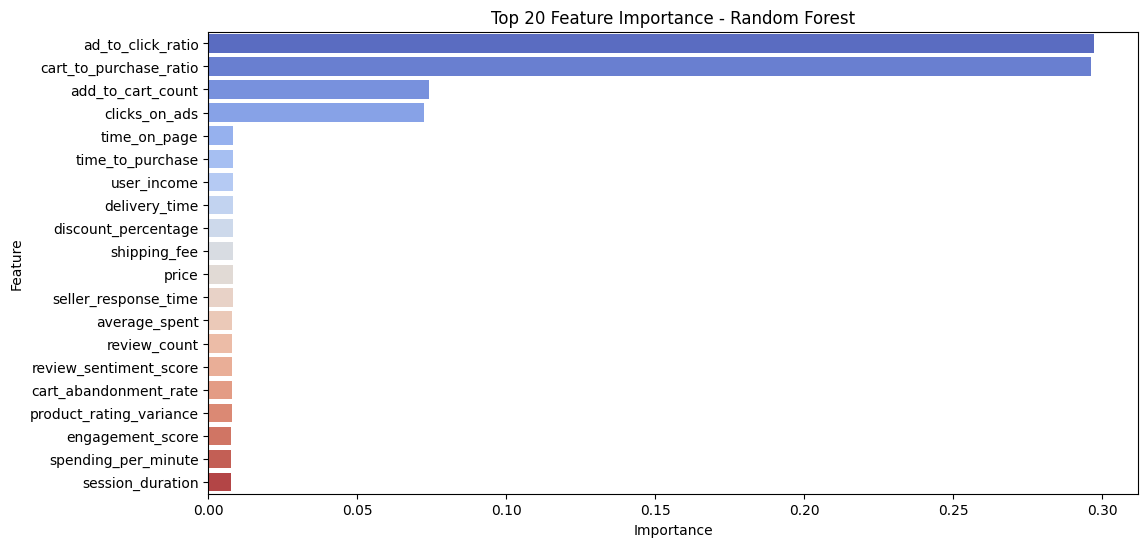

In [21]:
# Plot Feature Importance
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance.Importance[:20], y=feature_importance.Feature[:20], palette="coolwarm")
plt.title("Top 20 Feature Importance - Random Forest")
plt.show()

In [22]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Cross-validation for Random Forest
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
print("Random Forest Cross-Validation Accuracy: {:.4f} ± {:.4f}".format(np.mean(rf_cv_scores), np.std(rf_cv_scores)))

# Cross-validation for XGBoost
xgb_cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy')
print("XGBoost Cross-Validation Accuracy: {:.4f} ± {:.4f}".format(np.mean(xgb_cv_scores), np.std(xgb_cv_scores)))


Random Forest Cross-Validation Accuracy: 0.9655 ± 0.0016
XGBoost Cross-Validation Accuracy: 0.9975 ± 0.0004


In [23]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=500,        # Increase trees for stability
    max_depth=5,             # Reduce tree depth to prevent overfitting
    learning_rate=0.01,      # Lower learning rate for better generalization
    subsample=0.8,           # Use 80% of training data per tree
    colsample_bytree=0.8,    # Use 80% of features per tree
    reg_alpha=0.1,           # L1 regularization (lasso)
    reg_lambda=0.1,          # L2 regularization (ridge)
    random_state=42
)

# Train the regularized model
xgb_model.fit(X_train, y_train)

# Evaluate on test data
xgb_preds = xgb_model.predict(X_test)

from sklearn.metrics import accuracy_score, roc_auc_score
xgb_accuracy = accuracy_score(y_test, xgb_preds)
xgb_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])

print("Regularized XGBoost Accuracy:", xgb_accuracy)
print("Regularized XGBoost AUC:", xgb_auc)

Regularized XGBoost Accuracy: 0.9883888888888889
Regularized XGBoost AUC: 0.9999518144126733


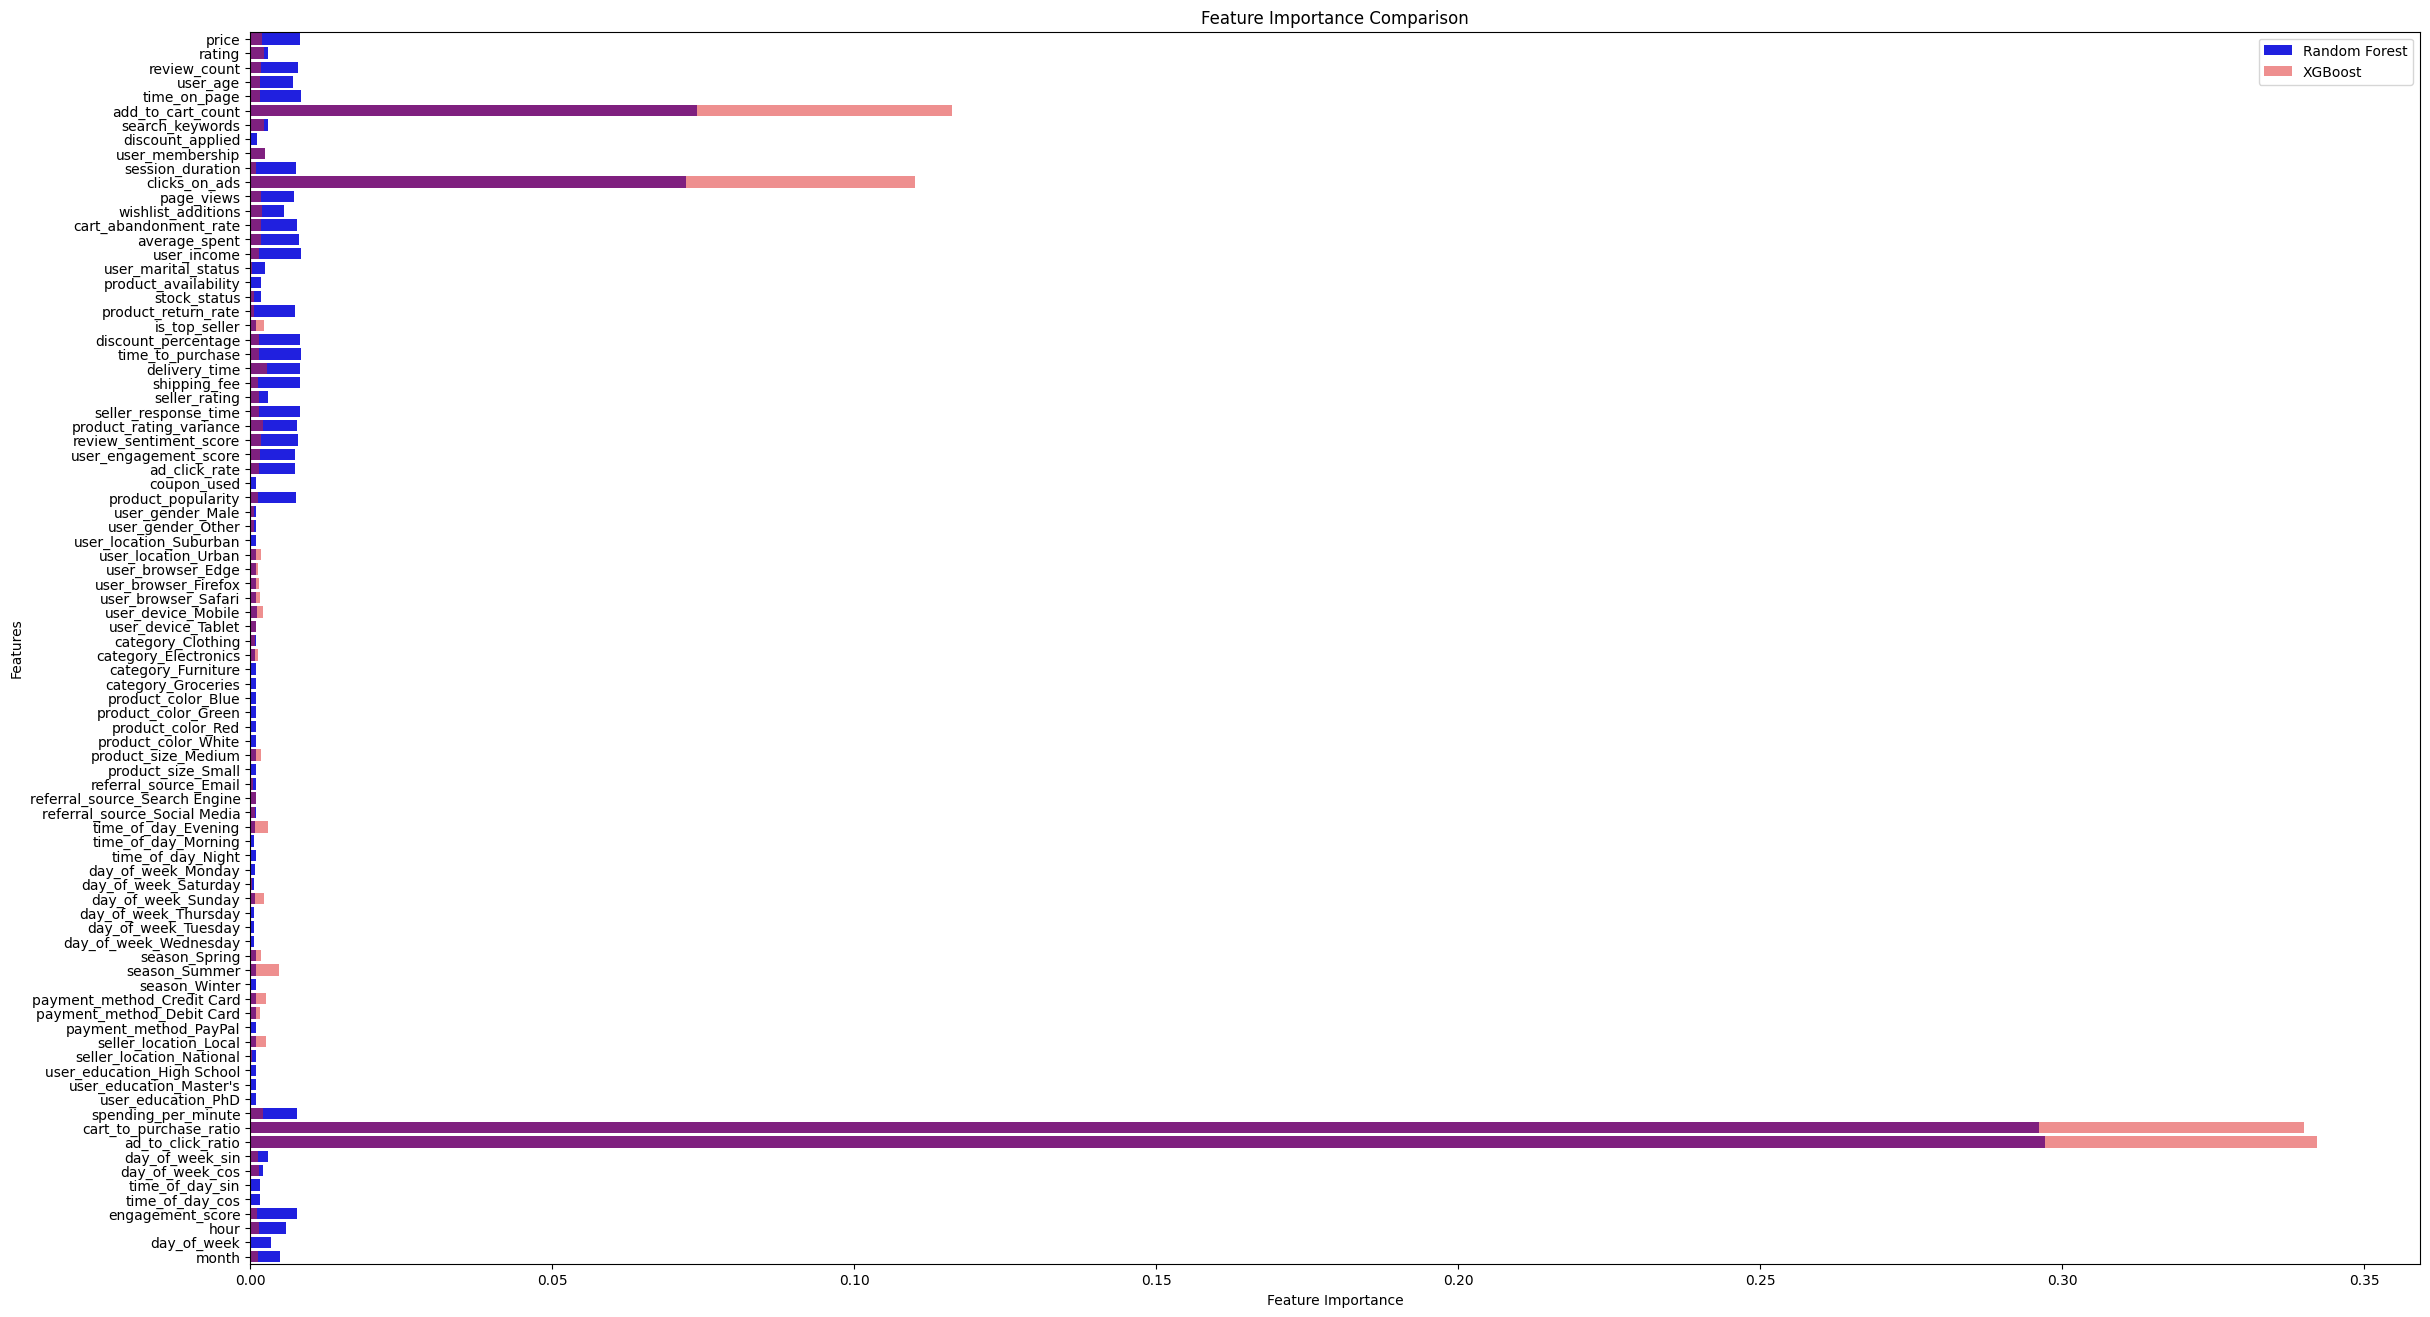

In [24]:
# Feature importance for Random Forest
rf_feature_importance = rf_model.feature_importances_
rf_features = X_train.columns

# Feature importance for XGBoost
xgb_feature_importance = xgb_model.feature_importances_
xgb_features = X_train.columns

# Plot feature importance
plt.figure(figsize=(28, 16))
sns.barplot(x=rf_feature_importance, y=rf_features, color="blue", label="Random Forest")
sns.barplot(x=xgb_feature_importance, y=xgb_features, color="red", alpha=0.5, label="XGBoost")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance Comparison")
plt.legend()
plt.show()


from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, n_jobs=-1, verbose=2)
rf_grid.fit(X_train, y_train)

# Best Parameters
print("Best Random Forest Parameters:", rf_grid.best_params_)

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2]
}

xgb_grid = RandomizedSearchCV(XGBClassifier(random_state=42), xgb_params, cv=3, n_jobs=-1, verbose=2, n_iter=10)
xgb_grid.fit(X_train, y_train)

print("Best XGBoost Parameters:", xgb_grid.best_params_)

In [39]:
# Create a DataFrame with all features initialized to 0
new_user = pd.DataFrame(columns=X_train.columns, data=np.zeros((1, len(X_train.columns))))

# Fill in the known values (adjust these values based on your needs)
new_user_values = {
	'price': 25,
	'rating': 5,
	'review_count': 2,
	'user_age': 10,
	'session_duration': 300,
	'add_to_cart_count': 1,
	'clicks_on_ads': 0,
	'page_views': 1,
	'user_engagement_score': 0.8,
}

# Update the DataFrame with known values
for feature, value in new_user_values.items():
	if feature in new_user.columns:
		new_user[feature] = value

# Make prediction using the model
prediction = xgb_model.predict(new_user)

print("Prediction:", "Will Purchase" if prediction[0] == 1 else "Will Not Purchase")
y_probs = xgb_model.predict_proba(new_user)  # Probabilities for both classes

print(f"Probability of NOT purchasing: {y_probs[0][0]:.4f}")
print(f"Probability of PURCHASING: {y_probs[0][1]:.4f}")

Prediction: Will Purchase
Probability of NOT purchasing: 0.0467
Probability of PURCHASING: 0.9533
